In [91]:
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '/local/S.Rasp/ML-Workshop-Data/dataset2/'

In [4]:
!ls $DATA_DIR

forecast_errors.png  nwp_ecmwf-ifs.nc	power_curve_single_turbine.png
metobs.nc	     nwp_envca-gdps.nc	README.md
ml_workshop_data.7z  nwp_ncep-gfs4.nc	windpark.nc


## Check out the data

### NWP data

In [35]:
nwp_ec = xr.open_dataset(DATA_DIR + 'nwp_ecmwf-ifs.nc')
nwp_en = xr.open_dataset(DATA_DIR + 'nwp_envca-gdps.nc')
nwp_nc = xr.open_dataset(DATA_DIR + 'nwp_ncep-gfs4.nc')

In [38]:
nwps = [nwp_ec, nwp_en, nwp_nc]
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws100m    (epoch_s, offset_s) float32 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) int32 1420070400 1420113600 1420156800 1420200000 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws1000mb  (epoch_s, offset_s) float32 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     ws925mb   (epoch_s, offset_s) float32 ...
     wd925mb   (epoch_s, offset_s) float32 ...
     tclcov    (epoch_s,

In [43]:
# Convert POSIX to datetime
for nwp in nwps:
    nwp['epoch_s'] = pd.to_datetime(nwp.epoch_s, unit='s')

In [44]:
nwps

[<xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws100m    (epoch_s, offset_s) float32 ...
     wd100m    (epoch_s, offset_s) float32 ...
     ws10m     (epoch_s, offset_s) float32 ...
     wd10m     (epoch_s, offset_s) float32 ...
     t2m       (epoch_s, offset_s) float32 ...
     blh       (epoch_s, offset_s) float32 ..., <xarray.Dataset>
 Dimensions:   (epoch_s: 1463, offset_s: 49)
 Coordinates:
   * epoch_s   (epoch_s) datetime64[ns] 2015-01-01 2015-01-01T12:00:00 ...
   * offset_s  (offset_s) int32 0 10800 21600 32400 43200 54000 64800 75600 ...
 Data variables:
     ws1000mb  (epoch_s, offset_s) float32 ...
     wd1000mb  (epoch_s, offset_s) float32 ...
     ws925mb   (epoch_s, offset_s) float32 ...
     wd925mb   (epoch_s, offset_s) float32 ...
     tclcov    (epoch_s, offset_

In [45]:
for nwp in nwps:
    print(nwp.epoch_s.min(), nwp.epoch_s.max())

<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'epoch_s' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'epoch_s' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')


In [110]:
nwp_ec.offset_s.max() / 60 / 60, (nwp_ec.offset_s[1] - nwp_ec.offset_s[0]) / 60

(<xarray.DataArray 'offset_s' ()>
 array(144.), <xarray.DataArray 'offset_s' ()>
 array(180.))

In [107]:
4*24

96

## Mast data

In [48]:
met = xr.open_dataset(DATA_DIR + 'metobs.nc'); met

<xarray.Dataset>
Dimensions:  (epoch_s: 63072)
Coordinates:
  * epoch_s  (epoch_s) int32 1420070400 1420071300 1420072200 1420073100 ...
Data variables:
    ws_avg   (epoch_s) float32 ...
    wd_avg   (epoch_s) float32 ...
    ws80m    (epoch_s) float32 ...
    ws34m    (epoch_s) float32 ...

In [49]:
# Convert to date time
met['epoch_s'] = pd.to_datetime(met.epoch_s, unit='s')

In [61]:
met.epoch_s.min(), met.epoch_s.max(), met.epoch_s[1] - met.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:45:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(900000000000, dtype='timedelta64[ns]'))

In [63]:
900000000000 / 1e9 / 60

15.0

## Target wind production data

In [64]:
pwr = xr.open_dataset(DATA_DIR + 'windpark.nc'); pwr

<xarray.Dataset>
Dimensions:   (epoch_s: 94608)
Coordinates:
  * epoch_s   (epoch_s) int32 1420070400 1420071000 1420071600 1420072200 ...
Data variables:
    power     (epoch_s) float32 ...
    rawpower  (epoch_s) float32 ...

In [65]:
# Convert to date time
pwr['epoch_s'] = pd.to_datetime(pwr.epoch_s, unit='s')

In [66]:
pwr.epoch_s.min(), pwr.epoch_s.max(), pwr.epoch_s[1] - pwr.epoch_s[0]

(<xarray.DataArray 'epoch_s' ()>
 array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array('2016-10-18T23:50:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'epoch_s' ()>
 array(600000000000, dtype='timedelta64[ns]'))

In [67]:
600000000000 / 1e9 / 60

10.0

## EDA

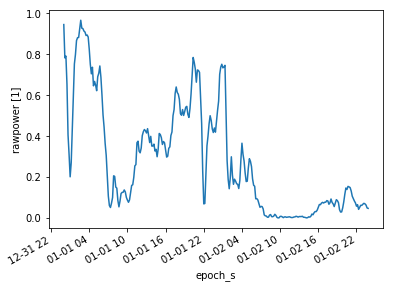

In [73]:
pwr.rawpower.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()

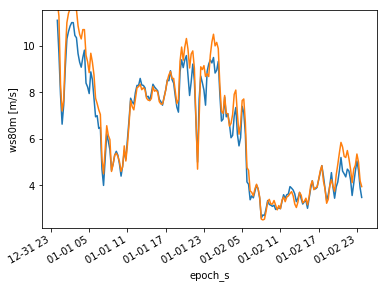

In [76]:
met.ws34m.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()
met.ws80m.sel(epoch_s=slice('2015-01-01', '2015-01-02')).plot()

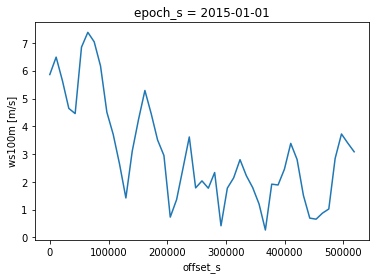

In [86]:
nwp_ec.ws100m.sel(epoch_s='2015-01-01T00').plot()

### Wind farm power curve

In [97]:
intersect = np.intersect1d(met.epoch_s, pwr.epoch_s)

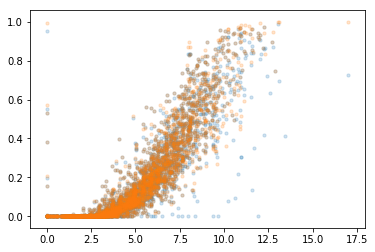

In [106]:
plt.scatter(met.ws34m.sel(epoch_s=intersect[::10]), pwr.rawpower.sel(epoch_s=intersect[::10]), s=10, alpha=0.2)
plt.scatter(met.ws34m.sel(epoch_s=intersect[::10]), pwr.power.sel(epoch_s=intersect[::10]), s=10, alpha=0.2)

## Split into datasets and prepare

total roughly 22 months

In [119]:
train_range = slice('2015-01-01', '2015-12-31')
valid_range = slice('2016-01-01', '2016-04-30')
test_range = slice('2016-05-01', '2016-10-18T23:50')

In [120]:
def split(ds):
    return ds.sel(epoch_s=train_range), ds.sel(epoch_s=valid_range), ds.sel(epoch_s=test_range)

### Option 1: Latest available NWP

In [ ]:
X = 